# Implicit Recommender System - ALS

In [1]:
# conventional libraries
import os
import calendar
import pandas as pd
import numpy as np
import datetime
import random

# data visualizations
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
import seaborn as sns
import matplotlib.pyplot as plt

# algorithm
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.sparse import coo_matrix
from implicit.als import AlternatingLeastSquares
from implicit.evaluation import ranking_metrics_at_k
from tqdm import tqdm
import scipy.sparse as sparse
import implicit
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import pickle

## Loading data

In [2]:
df = pd.read_csv('df_withC.csv', index_col=[0])
df.reset_index(drop=True, inplace=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399667 entries, 0 to 399666
Data columns (total 26 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   StockCode         399667 non-null  object 
 1   Description       399667 non-null  object 
 2   SC_Clean          399667 non-null  int64  
 3   Quantity          399667 non-null  int64  
 4   InvoiceDate       399667 non-null  object 
 5   UnitPrice         399667 non-null  float64
 6   CustomerID        399667 non-null  int64  
 7   Country           399667 non-null  object 
 8   StockCode_NR      399667 non-null  object 
 9   StockCode_L       399667 non-null  object 
 10  QuantityCanceled  399667 non-null  int64  
 11  TotalPrice        399667 non-null  float64
 12  QuantityInv       399667 non-null  int64  
 13  Sales             399667 non-null  float64
 14  Year              399667 non-null  int64  
 15  Month             399667 non-null  int64  
 16  Week              39

,StockCode,Description,SC_Clean,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,StockCode_NR,StockCode_L,...,Week,Year_Month,Hour,weekday_nr,Day,is_cancelled,weekday,Quarter,Date,RefundFlg
0,85123A,white hanging heart t-light holder,3716,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,85123,A,...,48,2010-12,8,3,1,0,Wednesday,Q3,2010-12-01 00:00:00,False
1,71053,white metal lantern,3724,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,71053,reg,...,48,2010-12,8,3,1,0,Wednesday,Q3,2010-12-01 00:00:00,False
2,84406B,cream cupid hearts coat hanger,861,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,84406,B,...,48,2010-12,8,3,1,0,Wednesday,Q3,2010-12-01 00:00:00,False
3,84029G,knitted union flag hot water bottle,1813,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,84029,G,...,48,2010-12,8,3,1,0,Wednesday,Q3,2010-12-01 00:00:00,False
4,84029E,red woolly hottie white heart.,2776,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,84029,E,...,48,2010-12,8,3,1,0,Wednesday,Q3,2010-12-01 00:00:00,False


In [3]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

## Dimensionality Reduction

In [4]:
df.columns

Index(['StockCode', 'Description', 'SC_Clean', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'StockCode_NR', 'StockCode_L',
       'QuantityCanceled', 'TotalPrice', 'QuantityInv', 'Sales', 'Year',
       'Month', 'Week', 'Year_Month', 'Hour', 'weekday_nr', 'Day',
       'is_cancelled', 'weekday', 'Quarter', 'Date', 'RefundFlg'],
      dtype='object')

In [5]:
df_limit = df[['InvoiceDate','Description','SC_Clean','Quantity','CustomerID']]
df_limit.rename(columns={'SC_Clean':'StockCode'}, inplace=True)
df_limit.head()

/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,InvoiceDate,Description,StockCode,Quantity,CustomerID
0,2010-12-01 08:26:00,white hanging heart t-light holder,3716,6,17850
1,2010-12-01 08:26:00,white metal lantern,3724,6,17850
2,2010-12-01 08:26:00,cream cupid hearts coat hanger,861,8,17850
3,2010-12-01 08:26:00,knitted union flag hot water bottle,1813,6,17850
4,2010-12-01 08:26:00,red woolly hottie white heart.,2776,6,17850


In [6]:
df = df_limit.copy()

## Reduce Sparsity

In [7]:
def threshold_ratings(df, uid_min, iid_min, max_iter=None):
    """Removes users and items with less than uid_min and iid_min event occurrences, respectively.
    Credits: https://www.ethanrosenthal.com/2016/10/19/implicit-mf-part-1/
    """
    n_users = df['CustomerID'].nunique()
    n_items = df['StockCode'].nunique()
    sparsity = float(df.shape[0]) / float(n_users * n_items) * 100
    print('Raw dataset info \n-----------------')
    print('Number of users: {}'.format(n_users))
    print('Number of items: {}'.format(n_items))
    print('Sparsity: {:4.3f}%'.format(sparsity))
    
    done, i = False, 0
    while not done:
        # When we exclude users with freq less than uid_min we might end up with new 
        # items with freq less than iid_min, so we will have to alternate back and forth
        starting_shape = df.shape[0]  # number of existing events

        uid_counts = df.groupby('CustomerID').size()  # user id frequencies
        df = df[~df['CustomerID'].isin(uid_counts[uid_counts < uid_min].index.tolist())]  # keep events with users with frequency >= uid_min

        iid_counts = df.groupby('StockCode').size()  # item id frequencies
        df = df[~df['StockCode'].isin(iid_counts[iid_counts < iid_min].index.tolist())]  # keep events with items with frequency >= iid_min

        ending_shape = df.shape[0]  # number of existing events after filters
        i += 1
        if starting_shape == ending_shape or i == max_iter:  # convergence happens
            done = True
    
    if not max_iter:
        assert(df.groupby('CustomerID').size().min() >= uid_min)
        assert(df.groupby('StockCode').size().min() >= iid_min)
    
    n_users = df['CustomerID'].nunique()
    n_items = df['StockCode'].nunique()
    sparsity = float(df.shape[0]) / float(n_users * n_items) * 100
    print('Limited dataset info \n-----------------')
    print('Number of iterations until convergence: {}'.format(i))
    print('Number of users: {}'.format(n_users))
    print('Number of items: {}'.format(n_items))
    print('Sparsity: {:4.3f}%'.format(sparsity))
    return df

In [8]:
# get limited dataset
df_limited = threshold_ratings(df, 5, 5)

Raw dataset info 
-----------------
Number of users: 4361
Number of items: 3888
Sparsity: 2.357%
Limited dataset info 
-----------------
Number of iterations until convergence: 3
Number of users: 4119
Number of items: 3304
Sparsity: 2.923%


## Train-test Split

In [9]:
# Train-test split
start_train = df_limited['InvoiceDate'].min()
start_test = start_train + pd.to_timedelta(15, unit='w')
end_test = start_test + pd.to_timedelta(5, unit='w')

# Create new limited df
df_limited = df_limited.loc[(df_limited['InvoiceDate'] > start_train) & (df_limited['InvoiceDate'] <= end_test)]

# Create train_split flag
df_limited['train_split'] = (df_limited['InvoiceDate'] <= start_test).astype(int)
print("Proportion of train events: {:.2f}".format(df_limited['train_split'].mean()))

Proportion of train events: 0.71


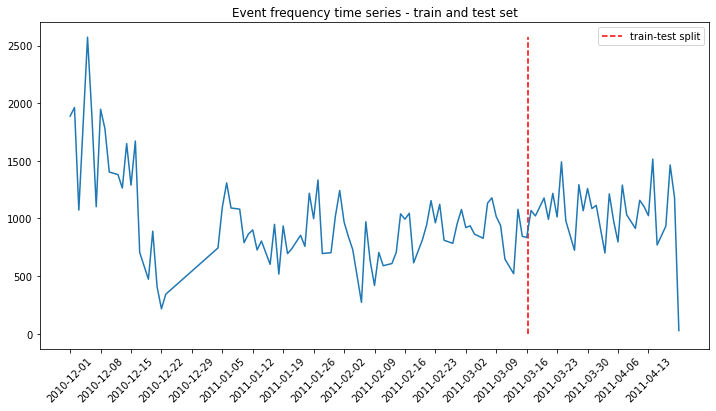

In [10]:
# Visualize train and test set
data = pd.DatetimeIndex(df_limited['InvoiceDate']).normalize().value_counts().sort_index()
fig = plt.figure(figsize=(12,6))
plt.plot(data.index, data.values, linestyle="-")
plt.xticks(np.arange(data.index[0], data.index[-1], pd.to_timedelta(7, unit='d')), rotation=45)
plt.vlines(start_test, 0, data.max(), linestyles='dashed', color='r', label='train-test split')
plt.legend()
plt.title('Event frequency time series - train and test set')
plt.show()

## Create train and test rating matrices

In [11]:
df_limited.head()

,InvoiceDate,Description,StockCode,Quantity,CustomerID,train_split
7,2010-12-01 08:28:00,hand warmer union jack,1562,6,17850,1
8,2010-12-01 08:28:00,hand warmer red polka dot,1559,6,17850,1
9,2010-12-01 08:34:00,assorted colour bird ornament,217,32,13047,1
10,2010-12-01 08:34:00,poppy's playhouse bedroom,2615,6,13047,1
11,2010-12-01 08:34:00,poppy's playhouse kitchen,2616,6,13047,1


In [12]:
# the Categoricals data structure consists of a categories array and an integer array of codes which point to 
# the real value in the categories array
user_cat = df_limited['CustomerID'].astype('category')
item_cat = df_limited['StockCode'].astype("category")

# create a sparse matrix of all the item/user/counts triples for the train set and test set
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html#scipy.sparse.coo_matrix
item_user_train = coo_matrix((df_limited['train_split'],
                              (item_cat.cat.codes,
                               user_cat.cat.codes))).tocsr()

# remove zero entries
item_user_train.eliminate_zeros()

# produce transpose of item_user_train
user_item_train = item_user_train.T

item_user_test = coo_matrix(((~df_limited['train_split'].astype(bool)).astype(int),
                             (item_cat.cat.codes,
                              user_cat.cat.codes))).tocsr()

# remove zero entries
item_user_test.eliminate_zeros()  

# produce transpose of item_user_test
user_item_test = item_user_test.T

# map each item and user category to a unique numeric code
user_map = dict(zip(user_cat, user_cat.cat.codes))
item_map = dict(zip(item_cat, item_cat.cat.codes))

def get_keys(value, dictionary):
    """Function to get dictionary keys with specifiec value"""
    return list(dictionary.keys())[list(dictionary.values()).index(value)]

# confirm shapes
print(f"train set shape: {item_user_train.shape} and test set shape: {item_user_test.shape}")

# check sparsity
pzeros_train = 100 * (1 - item_user_train.count_nonzero() / (item_user_train.shape[0] * item_user_train.shape[1]))
pzeros_test = 100 * (1 - item_user_test.count_nonzero() / (item_user_test.shape[0] * item_user_test.shape[1]))
print(f"train set percentage of zeros: {pzeros_train} and test set percentage of zeros: {pzeros_test}")

train set shape: (2665, 2304) and test set shape: (2665, 2304)
train set percentage of zeros: 98.92548402647488 and test set percentage of zeros: 99.50893787784032


In [13]:
# users with no items on the train set and not items on the test set
zero_users_test = (np.squeeze(np.asarray(user_item_test.sum(axis=1))) == 0).nonzero()[0]
zero_users_train = (np.squeeze(np.asarray(user_item_train.sum(axis=1))) == 0).nonzero()[0]
set(zero_users_test).intersection(zero_users_train)

set()

In [14]:
# most frequent user, item pair in train set
item_id, user_id = np.unravel_index(item_user_train.argmax(), item_user_train.shape)
item_id, user_id = get_keys(item_id, item_map), get_keys(user_id, user_map)
df_limited.loc[(df_limited['CustomerID'] == user_id) & (df_limited['StockCode'] == item_id) & (df_limited['train_split'] == 1)]

,InvoiceDate,Description,StockCode,Quantity,CustomerID,train_split
1511,2010-12-01 14:41:00,chilli lights,725,24,17841,1
4641,2010-12-03 14:35:00,chilli lights,725,24,17841,1
9170,2010-12-06 14:51:00,chilli lights,725,30,17841,1
19878,2010-12-14 14:40:00,chilli lights,725,24,17841,1
24043,2010-12-19 13:59:00,chilli lights,725,24,17841,1
26534,2011-01-04 12:51:00,chilli lights,725,48,17841,1
31341,2011-01-09 14:36:00,chilli lights,725,34,17841,1
33589,2011-01-12 12:31:00,chilli lights,725,3,17841,1
35928,2011-01-16 13:51:00,chilli lights,725,30,17841,1
38373,2011-01-19 14:39:00,chilli lights,725,24,17841,1


## Implementing Alternative Least Squares (ALS)

In [15]:
# initialize a model
alpha = 20  # as we observe more evidence for positive preference, our confidence in pui = 1 increases according to alpha (rate of increase)
als_model = AlternatingLeastSquares(factors=200, regularization=0.01, iterations=30, random_state=0)

# train the model on a sparse matrix of item/user/confidence weights
# os.environ['MKL_NUM_THREADS'] = '1'
# os.environ['OPENBLAS_NUM_THREADS'] = '1'
# about the alpha hyperparameter: https://github.com/benfred/implicit/issues/199#issuecomment-490350326
als_model.fit((item_user_train * alpha).astype('double'))

In [16]:
def get_keys(value, dictionary):
    """Function to get dictionary keys with specifiec value"""
    return list(dictionary.keys())[list(dictionary.values()).index(value)]

def get_values(key, dictionary):
    """Function to get dictionary values from a specific key"""
    return(dictionary[key])

In [17]:
gloss = df[['StockCode','Description']]
gloss.drop_duplicates(subset=['StockCode'],inplace=True)
gloss.reset_index(drop=True,inplace=True)
gloss.set_index('StockCode',inplace=True)
gloss.head()

/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Description
StockCode,
3716,white hanging heart t-light holder
3724,white metal lantern
861,cream cupid hearts coat hanger
1813,knitted union flag hot water bottle
2776,red woolly hottie white heart.


In [18]:
my_dict = gloss.to_dict()
my_dict = my_dict.pop('Description', None)

In [19]:
# recommend items for a user. 
# the recommended items have the largest inner product with the user vector
user_id = list(user_map.keys())[0]
recommendations = als_model.recommend(user_map[user_id], user_item_train)
#final_pred = list(map(lambda x: (get_values(x[0], my_dict), x[1]), new_recs))[:5]
new_recs = list(map(lambda x: (get_keys(x[0], item_map), x[1]), recommendations))

###
new_recs_df = pd.DataFrame(new_recs, columns=['stock','score'])
new_recs_df['description'] = new_recs_df['stock'].apply(lambda x: get_values(x, my_dict))
new_recs_df = new_recs_df[['stock','description','score']]
###

In [20]:
stockids = []
names = []
scores = []

for i in range(len(new_recs_df)):
    stockids.append(new_recs_df.iloc[i][0])
    names.append(new_recs_df.iloc[i][1])
    scores.append(new_recs_df.iloc[i][2])    

In [21]:
new_recs_df = pd.DataFrame(new_recs, columns=['stock','score'])
new_recs_df['description'] = new_recs_df['stock'].apply(lambda x: get_values(x, my_dict))
new_recs = pd.DataFrame()

In [22]:
final_pred = list(map(lambda x: (get_values(x[0], my_dict), x[1]), new_recs))[:5]

In [23]:
cwd = os.getcwd()
backOne = os.path.dirname(cwd)

#Serializing the model
with open(str(backOne) + "/Application/model/model.pkl", 'wb') as f:
    pickle.dump(als_model, f)

#De-Serializing the model
with open(str(backOne) + "/Application/model/model.pkl", 'rb') as f:
    clf_loaded = pickle.load(f)
    
#Check the pickle file by inputing the variables
model = pickle.load(open(str(backOne) + "/Application/model/model.pkl",'rb'))

## Product Recommendation

In [24]:
# the recommended items have the largest inner product with the user vector
user_id = list(user_map.keys())[0]
recommendations = als_model.recommend(user_map[user_id], user_item_train)
final_pred = list(map(lambda x: (get_values(x[0], my_dict), x[1]), new_recs))[:5]
new_recs = list(map(lambda x: (get_keys(x[0], item_map), x[1]), recommendations))

###
new_recs_df = pd.DataFrame(new_recs, columns=['stock','score'])
new_recs_df['description'] = new_recs_df['stock'].apply(lambda x: get_values(x, my_dict))
new_recs_df = new_recs_df[['stock','description','score']]
###

In [25]:
# find related items
# the related items have the largest inner product with the item vector
item_id = list(item_map.keys())[0]
related = als_model.similar_items(item_map[item_id])
list(map(lambda x: (get_keys(x[0], item_map), x[1]), related))

[(1562, 1.0),
 (1561, 0.67777795),
 (1560, 0.6359729),
 (1557, 0.6226144),
 (1556, 0.56480587),
 (2680, 0.46546838),
 (808, 0.45501885),
 (2712, 0.43898374),
 (3140, 0.43812343),
 (2533, 0.437591)]

## Building the Popular Model as baseline

In [26]:
# Baseline: Recommend the most popular items to every user
class PopularRecommender():
    """Baseline Recommender that always suggests the most popular items to every user.
    """
    def fit(self, item_users):
        self.item_id_sort = np.argsort(np.squeeze(np.asarray(item_users.sum(axis=1).reshape(-1))))[::-1]
    
    def recommend(self, userid, user_items, N=10, filter_already_liked_items=None, filter_items=None, recalculate_user=None):
        if filter_already_liked_items != None or filter_items != None or recalculate_user != None:
            raise NotImplementedError("filter_already_liked_items, filter_items and recalculate_user aren't support yet")
        
        return list(zip(self.item_id_sort[:N], range(1, N + 1)))

In [27]:
# Fitting PopularRecommender model
pop_model = PopularRecommender()
pop_model.fit(item_user_train)

## Model Evaluation - AUC

In [28]:
# Evaluate models. 
# Precision at K, Mean Average Precision at K, Normalized Discounted Cumulative Gain at K, AUC at K
eval_models = {'pop_model': pop_model, 'als_model': als_model}
eval_table = {}
for k, v in eval_models.items():
    eval_table[k] = ranking_metrics_at_k(v, user_item_train, user_item_test, K=10, show_progress=True, num_threads=0)
eval_table = pd.DataFrame(eval_table)
eval_table

,pop_model,als_model
precision,0.099316,0.049658
map,0.049085,0.019590
ndcg,0.109797,0.048131
auc,0.523161,0.508205
